In [1]:
import numpy as np
import pandas as pd

from pathlib import Path

from ftplib import FTP

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-dark-palette')
%matplotlib inline

Below is code to automatically grab a file from the FTP for RNAcentral. FTPlib doesn't like large files though, so I ended up doing it manually. 

In [2]:
# HOSTNAME = 'ftp.ebi.ac.uk'

# ftp = FTP(HOSTNAME)

# ftp.login()

# ftp.cwd('pub/databases/RNAcentral/current_release/json')

# filename = 'ensembl-xref-1-100001.json'

# with open(filename, "w") as rna_json:
#     ftp.retrlines(f"RETR {filename}", rna_json.write)


Instead of automated requests, I grabbed a few of the JSON files from the FTP, which can be read in with the following function. 

In [3]:
def load_rna(fname, inc_other=True, merge_other=True, simple_descrips=False, drop=True):
    rna = pd.read_json(fname)
    
    # drop extra columns which reference external databases -- always
    rna = rna.drop(['xrefs', 'md5'], axis=1)
    
    # make the column names pretty
    cols = {'rnacentral_id': 'RNA ID', 'description': 'Description', 'sequence':'Sequence', 'rna_type': 'RNA Type', 'taxon_id': 'Taxon ID'}
    rna = rna.rename(columns=cols)
    
    # remove underscores from RNA type
    rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('_', ' ')), axis=1)
    
    # combine the 'other', 'misc', 'nc', and 'lnc' types\n",
    if merge_other:
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('misc RNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('lncRNA', 'other')), axis=1)
        rna['RNA Type'] = rna.apply(lambda row : (row['RNA Type'].replace('ncRNA', 'other')), axis=1)

    # drop rows with unclassified RNAs? 
    if not inc_other:
        rna = rna[rna['RNA Type'] != 'other']
        
        if not merge_other:
            rna = rna[rna['RNA Type'] != 'misc RNA']
            rna = rna[rna['RNA Type'] != 'ncRNA']
            rna = rna[rna['RNA Type'] != 'lncRNA']
    
    # Remove everything except latin name from species description
    if simple_descrips:
        rna['Description'] = rna.apply(lambda row : (row['Description'].split(' ')[0] + ' ' + row['Description'].split(' ')[1]), axis=1)\
        
    # drop extra columns with unnecessary info -- optional
    if drop:
        rna = rna.drop(['Taxon ID', 'RNA ID', 'Description'], axis=1)
    
    return rna



In [4]:
# load a batch of data files from RNAcentral or load in a single file?
load_all = False

if load_all:
    p = Path()
    p = p / 'data'
    files = p.glob('ensembl-*')
    rna = pd.DataFrame()

    for file in files:
        try: 
            print(f'Loading data from {str(file)}')
            rna = pd.concat([rna, load_rna(str(file), inc_other=False)])
        except:
            print(f'Could not load data from {str(file)}')

    print('All data loaded.')

else:
    rna = load_rna('data\ensembl-xref-34100001-34200001.json')


In [5]:
def contract_families(types):
    
    classification = []
    
    classes = {'cis-reg': ['IRES', 'leader', 'riboswitch'], 
               'intron': ['autocatalytically spliced intron', 'intron gpI', 'intron gpII', 'intron'],
                  'gene': ['tRNA', 'rRNA', 'snRNA', 'snoRNA', 'pre miRNA', 'hammerhead ribozyme', 'SRP RNA', 'sRNA', 'Y RNA',
                          'RNase P RNA', 'lncRNA', 'tmRNA', 'RNase MRP RNA', 'vault RNA', 'ribozyme', 'miRNA', 'antisense RNA',
                          'telomerase RNA', 'scRNA', 'precursor RNA', 'scaRNA', 'piRNA'], 'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for c  in classes.keys():
            if t in classes[c]:
                classification.append(c)
                flag = True
                break

        if not flag:
            classification.append(t)


    family = []
    
    families = {'tRNA': ['tRNA', 'tmRNA'], 'rRNA': ['rRNA', 'SRP RNA', 'Y RNA'], 'snRNA': 'snRNA', 
                'snoRNA': ['snoRNA', 'scRNA', 'scaRNA'], 'miRNA': ['pre miRNA', 'miRNA', 'piRNA'], 'precursor RNA': ['precursor RNA'],
                'ribozyme': ['hammerhead ribozyme', 'RNase P RNA', 'RNase MRP RNA', 'ribozyme', 'autocatalytically spliced intron'], 
                'sRNA': ['sRNA'], 'antisense': ['antisense'], 'vault RNA': ['vault RNA'], 'telomerase RNA': ['telomerase RNA'],
                'artificial': ['guide RNA', 'siRNA']}

    for t in types:
        flag = False
        for f in families.keys():
            if t in families[f]:
                family.append(f)
                flag = True
                break

        if not flag:
            family.append(t)
            
    return classification, family

In [6]:
rna['RNA Class'], rna['RNA Family'] = contract_families(rna['RNA Type'])
rna.head()

,Sequence,RNA Type,RNA Class,RNA Family
0,GATGAAGAACGCAGCGAAATGCGATAAGTAATGTGAATTGCAGAAT...,other,other,other
1,GATGAACGCTGGCGGCGTGCCTAATACATGCAAGTCGAGCGAACGG...,rRNA,gene,rRNA
2,CGACAAGCAATTAGCGAGTTGTCACGTGAGCTCTCGACCAATGAGA...,other,other,other
3,TGAGAGTTTGATCTGGCTCAGGACGAACGCTGGCGGCGTGCTTAAC...,rRNA,gene,rRNA
4,ATTGAACGCTGGCGGCAGGCCTAACACATGCAAGTCGAGCGGATGA...,rRNA,gene,rRNA


In [7]:
merge_sequence = rna.groupby("Sequence").agg({'RNA Type':'first'}).reset_index()
print(len(rna))
print(len(merge_sequence))

53580
53014


In [8]:
def visual_comp_merged(original_seq, merged_seq, cat='RNA Type'):
    typcount = original_seq[cat].value_counts()
    mtypcount = merged_seq[cat].value_counts()
    xpos = np.arange(0, 2*len(typcount.index), 2)
    
    plt.figure()
    plt.bar(x=xpos, height=typcount, log=True, width=-0.8, align='edge', tick_label=typcount.index)
    plt.bar(x=xpos, height=mtypcount, log=True, width=0.8, align='edge')

    plt.xticks(rotation=90)
    plt.xlabel(f'{cat}')
    plt.ylabel('Log count');

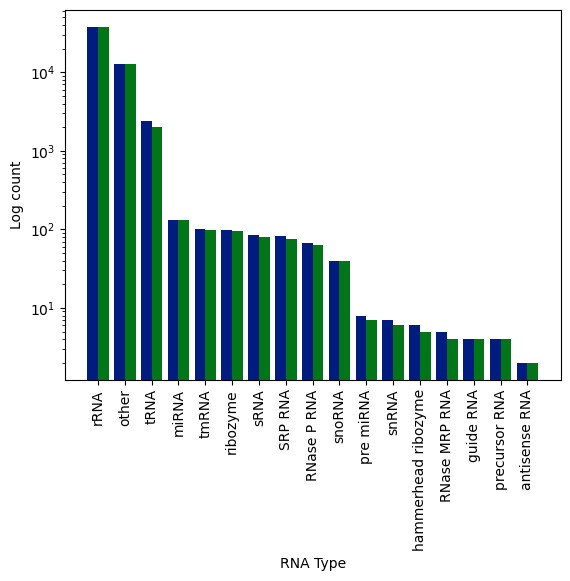

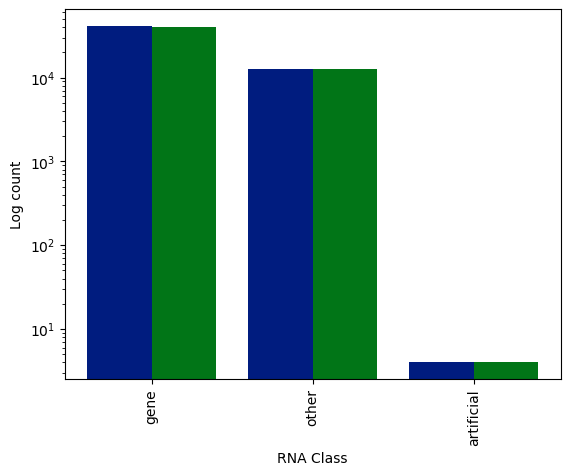

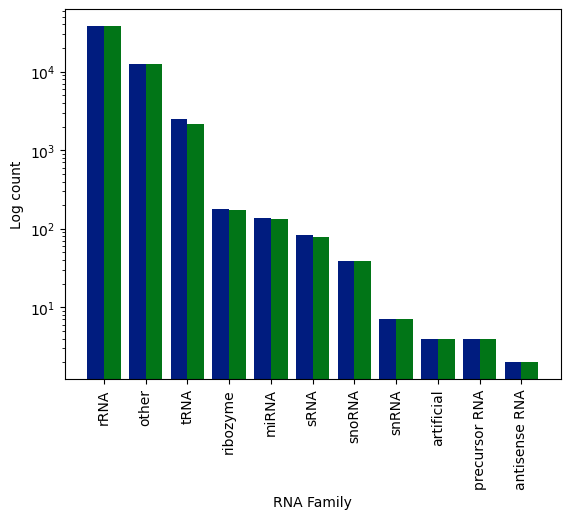

In [9]:
merge_sequence['RNA Class'], merge_sequence['RNA Family'] = contract_families(merge_sequence['RNA Type'])
visual_comp_merged(rna, merge_sequence)
visual_comp_merged(rna, merge_sequence, 'RNA Class')
visual_comp_merged(rna, merge_sequence, 'RNA Family')

Feature engineering below includes: sequence length, nucleic acid ratios (ratios of A:T:C:G), ...

In [85]:
merge_sequence['Sequence len'] = merge_sequence['Sequence'].str.len()

seq = merge_sequence.loc[:, 'Sequence']

def nucleic_acid_ratios(target):
    A = 0
    C = 0
    T = 0
    G = 0
    N = 0
    bad_vals = 0;
    for ch in target:
        if (ch == "A"):
            A += 1
        elif (ch == 'C'):
            C += 1;
        elif (ch == 'T'):
            T += 1;
        elif (ch == 'G'):
            G += 1;
        elif (ch == 'N'):
            N += 1;
        else:
            bad_vals += 1

    seq_len = len(target)
    a_rat = A / seq_len
    c_rat = C / seq_len
    t_rat = T / seq_len
    g_rat = G / seq_len
    n_rat = N / seq_len
    
    return a_rat, c_rat, t_rat, g_rat, n_rat;



In [86]:
df2 = pd.DataFrame()
print (a_rat)
print (c_rat)
print (g_rat)
print (t_rat)
print (n_rat)

merge_sequence["A Ratio"] = 0
merge_sequence["C Ratio"] = 0
merge_sequence["T Ratio"] = 0
merge_sequence["G Ratio"] = 0
merge_sequence["N Ratio"] = 0
# print(test)
#    merge_sequence.concat({"A ratio": a_rat}, ignore_index=True)
for i in range (len(seq)):
    a_rat, c_rat, t_rat, g_rat, n_rat = nucleic_acid_ratios(seq[i])
    merge_sequence.loc[i, "A Ratio"] = a_rat
    merge_sequence.loc[i, "C Ratio"] = c_rat
    merge_sequence.loc[i, "T Ratio"] = t_rat
    merge_sequence.loc[i, "G Ratio"] = g_rat
    merge_sequence.loc[i, "N Ratio"] = n_rat

merge_sequence.head()

0.04411764705882353
0.014705882352941176
0.014705882352941176
0.9264705882352942
0.0


,Sequence,A Ratio,RNA Type,RNA Class,RNA Family,Sequence len,C Ratio,T Ratio,G Ratio,N Ratio
0,AAAAAAAAAAAAAAAAAAAAAAAATCCCTTTTTTTTTTTTTTTTTT...,0.363095,ribozyme,gene,ribozyme,168,0.136905,0.404762,0.095238,0.0
1,AAAAAAAAAAAAAAAGTCCAAAAAAACATGAAAAAAAGTCCAAAAA...,0.523810,ribozyme,gene,ribozyme,84,0.095238,0.297619,0.083333,0.0
2,AAAAAAAAAAAAAAGAAAAAAAAAAGGCATGCACATGTTGTTTCGG...,0.305344,ribozyme,gene,ribozyme,131,0.122137,0.358779,0.213740,0.0
3,AAAAAAAAAAAAAAGAGAAGAGTAGGATGTCACCTCCTTGTCATCA...,0.241071,ribozyme,gene,ribozyme,112,0.196429,0.419643,0.142857,0.0
4,AAAAAAAAAATCAGAATCTACTTTTTCTTGGGGGATAACGTAGGGA...,0.296178,rRNA,gene,rRNA,314,0.191083,0.213376,0.299363,0.0
